In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression  
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, GridSearchCV


import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 

%config InlineBackend.figure_format = 'retina'

# to display all columns and rows:
pd.set_option('display.max_columns', None); pd.set_option('display.max_rows', None);

df = pd.read_csv("/kaggle/input/churn-predictions-personal/Churn_Predictions.csv", index_col=0)
df.head()

In [ ]:
df[df["Balance"]==0].groupby(["NumOfProducts"]).agg({"EstimatedSalary":"mean"})

In [ ]:
df.info()

In [ ]:
df.shape

In [ ]:
df.describe([0.10,0.25,0.50,0.75,0.90,0.95,0.99]).T

In [ ]:
from pandas_profiling import ProfileReport

profile = ProfileReport(df, title="Pandas Profiling Report", progress_bar=False)
profile.to_widgets()

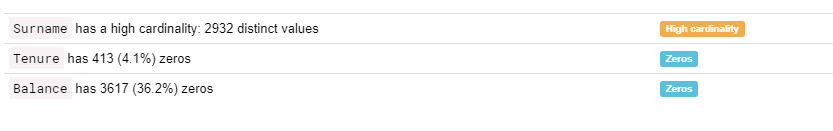

In [ ]:
df.shape

In [ ]:
df["CreditScore"].plot.hist(bins=10, alpha=0.5)

In [ ]:
df["Geography"].value_counts()

In [ ]:
df["Gender"].value_counts()

In [ ]:
df.groupby(["Geography","Gender","Exited"]).agg({"Exited":"count"})

In [ ]:
df["Age"].plot.hist(bins=10, alpha=0.5)

In [ ]:
df["Tenure"].plot.hist(bins=10, alpha=0.5)

In [ ]:
df["Balance"].plot.hist(bins=10, alpha=0.5)

In [ ]:
df["NumOfProducts"].value_counts()

In [ ]:
df["HasCrCard"].value_counts()

In [ ]:
df["IsActiveMember"].value_counts()

In [ ]:
df["EstimatedSalary"].plot.hist(bins=10, alpha=0.5)

In [ ]:
f, ax = plt.subplots(1, 2, figsize = (15, 7))
f.suptitle("Churn?", fontsize = 18.)
_ = df.Exited.value_counts().plot.bar(ax = ax[0], rot = 0, color = (sns.color_palette()[0], sns.color_palette()[2])).set(xticklabels = ["No", "Yes"])
_ = df.Exited.value_counts().plot.pie(labels = ("No", "Yes"), autopct = "%.2f%%", label = "", fontsize = 13., ax = ax[1],\
colors = (sns.color_palette()[0], sns.color_palette()[2]), wedgeprops = {"linewidth": 1.5, "edgecolor": "#F7F7F7"}), ax[1].texts[1].set_color("#F7F7F7"), ax[1].texts[3].set_color("#F7F7F7")

# Data Preprocessing

In [ ]:
df.drop(["CustomerId", "Surname"], axis = 1, inplace = True)

In [ ]:
df.isnull().sum()

In [ ]:
for feature in df.select_dtypes(include=['float',"int"]):
    
    Q1 = df[feature].quantile(0.05)
    Q3 = df[feature].quantile(0.95)
    IQR = Q3-Q1
    lower = Q1- 1.5*IQR
    upper = Q3 + 1.5*IQR
    
    if df[(df[feature] > upper)].any(axis=None):
        print(feature,"yes")
    else:
        print(feature, "no")

In [ ]:
# Correlation matrix graph of the data set
f, ax = plt.subplots(figsize= [15,10])
sns.heatmap(df.corr(), annot=True, fmt=".2f", ax=ax, cmap = "magma" )
ax.set_title("Correlation Matrix", fontsize=20)
plt.show()

In [ ]:
df.groupby(["NumOfProducts","Exited"]).agg({"Exited":"count"})

In [ ]:
cat_df = df[["Geography","Gender"]]

In [ ]:
bool_df = df[["IsActiveMember","HasCrCard"]]

In [ ]:
df.drop(["IsActiveMember","HasCrCard","Geography","Gender"], axis = 1, inplace = True)

In [ ]:
cat_df = pd.get_dummies(cat_df, drop_first=True)

In [ ]:
y = df["Exited"]
X = df.drop(["Exited"], axis = 1)
cols = X.columns
index = X.index

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(X)
X = pd.DataFrame(X,columns=cols,index=index)
X = pd.concat([X,bool_df,cat_df],axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.20, 
                                                    random_state=12345)

In [ ]:
#Dengesiz bir veri seti olduğu için örneklem sayısını arttıracağız
from imblearn.combine import SMOTETomek

smk = SMOTETomek()
X_train, y_train = smk.fit_sample(X_train, y_train)

X_test, y_test = smk.fit_sample(X_test, y_test)

In [ ]:
# Tum modellerin train validasyon skorları

models = []
models.append(('LR', LogisticRegression( random_state = 12345)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier( random_state = 12345)))
models.append(('RF', RandomForestClassifier( random_state = 12345)))
models.append(('SVM', SVC(gamma='auto', random_state = 12345)))
models.append(('XGB', GradientBoostingClassifier( random_state = 12345)))
models.append(("LightGBM", LGBMClassifier( random_state = 12345)))

# evaluate each model in turn
results = []
names = []

In [ ]:
for name, model in models:
    
        base = model.fit(X_train,y_train)
        y_pred = base.predict(X_test)
        acc_score = accuracy_score(y_test, y_pred)
        results.append(acc_score)
        names.append(name)
        msg = "%s: %f" % (name, acc_score)
        print(msg)

In [ ]:
# Tum modellerin değişken önem düzeyleri

models2 = []
models2.append(('CART', DecisionTreeClassifier( random_state = 12345)))
models2.append(('RF', RandomForestClassifier( random_state = 12345)))
models2.append(('XGB', GradientBoostingClassifier( random_state = 12345)))
models2.append(("LightGBM", LGBMClassifier( random_state = 12345)))

In [ ]:
for name, model in models2:
        base = model.fit(X_train,y_train)
        y_pred = base.predict(X_test)
        acc_score = accuracy_score(y_test, y_pred)
        feature_imp = pd.Series(base.feature_importances_,
                        index=X.columns).sort_values(ascending=False)

        sns.barplot(x=feature_imp, y=feature_imp.index)
        plt.xlabel('Değişken Önem Skorları')
        plt.ylabel('Değişkenler')
        plt.title(name)
        plt.show()

# Confusion Matrix

In [ ]:
from sklearn.metrics import  accuracy_score, f1_score, precision_score,confusion_matrix, recall_score, roc_auc_score
y_pred = model.predict(X_test)
cm_xgb = confusion_matrix(y_test, y_pred=y_pred)

In [ ]:
TP = cm_xgb[1, 1]
TN = cm_xgb[0, 0]
FP = cm_xgb[0, 1]
FN = cm_xgb[1, 0]

In [ ]:
from matplotlib import rc,rcParams
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.rcParams.update({'font.size': 19})
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title,fontdict={'size':'16'})
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45,fontsize=12,color="blue")
    plt.yticks(tick_marks, classes,fontsize=12,color="blue")
    rc('font', weight='bold')
    fmt = '.1f'
    thresh = cm.max()
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="red")

    plt.ylabel('True label',fontdict={'size':'16'})
    plt.xlabel('Predicted label',fontdict={'size':'16'})
    plt.tight_layout()

In [ ]:
import itertools
plot_confusion_matrix(confusion_matrix(y_test, y_pred=y_pred), classes=['Non Churn','Churn'],
                      title='Confusion matrix')

In [ ]:
tn, fp, fn, tp = cm_xgb.ravel()
print("True Negatives: ",tn)
print("False Positives: ",fp)
print("False Negatives: ",fn)
print("True Positives: ",tp)

In [ ]:
df_pred = pd.DataFrame(data=[],columns=["y_test"])
df_pred["y_pred"] = y_pred
df_pred["y_test"] = y_test
df_pred.index = df_pred.index + 1

In [ ]:
df_pred.head()

In [ ]:
FP_predicts_indexes = [] 
TP_predicts_indexes=[]
FN_predicts_indexes =[]
TN_predicts_indexes  = []
for index, row in df_pred.iterrows():
    if row['y_test'] == 0 and row['y_pred'] == 1:
        FP_predicts_indexes.append(row.name)
    elif row['y_test'] == 1 and row['y_pred'] == 1:
        TP_predicts_indexes.append(row.name)
    elif row['y_test'] == 0 and row['y_pred'] == 0:
        TN_predicts_indexes.append(row.name)
    elif row['y_test'] == 1 and row['y_pred'] == 0:
        FN_predicts_indexes.append(row.name)

In [ ]:
#gerçekte diyabet olmayan doğru non-diyabet tahminler
df_pred.loc[TN_predicts_indexes,"tahmin_sonuc"] = "TN"
#gerçekte diyabet olan doğru tahmins
df_pred.loc[TP_predicts_indexes,"tahmin_sonuc"] = "TP"
#gerçekte diyabet olamayan yanlış tahmins
df_pred.loc[FP_predicts_indexes,"tahmin_sonuc"] = "FP"
#gerçekte diyabet olan ama yanlış teşhisler
df_pred.loc[FN_predicts_indexes,"tahmin_sonuc"] = "FN"
df_pred.head()

In [ ]:
X_test.index = X_test.index + 1
df_pred = pd.concat([df_pred,X_test],axis=1)

In [ ]:
df_pred.shape

In [ ]:
df_hata = df_pred[(df_pred["tahmin_sonuc"]=="FP") | (df_pred["tahmin_sonuc"]=="FN")]

In [ ]:
df_hata.head()

In [ ]:
df_hata["IsActiveMember"].value_counts()

In [ ]:
df_hata["HasCrCard"].value_counts()

In [ ]:
df_hata["Geography_Germany"].value_counts()

In [ ]:
df_hata["Geography_Spain"].value_counts()

In [ ]:
df_hata["Gender_Male"].value_counts()

# RF

In [ ]:
rf_params = {"n_estimators" :[100,200,500], 
             "max_features": [3,5,8,], 
             "min_samples_split": [2,5,8],
            "max_depth": [3,5,8]}

rf_model = RandomForestClassifier(random_state = 12345)

gs_cv = GridSearchCV(rf_model, 
                    rf_params,
                    cv = 10,
                    n_jobs = -1,
                    verbose = 2).fit(X_train, y_train)

rf_tuned = RandomForestClassifier(**gs_cv.best_params_,random_state=12345)
rf_tuned = rf_tuned.fit(X_train,y_train)
y_pred = rf_tuned.predict(X_test)
acc_score = accuracy_score(y_test, y_pred)
print(acc_score)

# XGBoost

In [ ]:
xgb = GradientBoostingClassifier(random_state=12345)

xgb_params = {"n_estimators": [100, 500, 1000],
              "subsample" : [0.6, 0.8, 1.0],
              "max_depth" : [3, 4, 5],
              "learning_rate" : [0.1, 0.01, 0.05,],
              "min_samples_split" : [2, 5, 10]}

xgb_cv_model = GridSearchCV(xgb, 
                     xgb_params, 
                     cv = 5, 
                     n_jobs = -1, 
                     verbose = 2).fit(X_train,y_train)

xgb_tuned = GradientBoostingClassifier(**xgb_cv_model.best_params_,random_state=12345)
xgb_tuned = xgb_tuned.fit(X_train,y_train)
y_pred = xgb_tuned.predict(X_test)
acc_score = accuracy_score(y_test, y_pred)
print(acc_score)

# LGBM

In [ ]:
lgbm = LGBMClassifier(random_state = 12345)

lgbm_params = {"learning_rate": [0.01, 0.05, 0.1],
              "n_estimators": [100, 500, 1000],
              "max_depth":[3, 5, 8]}

gs_cv = GridSearchCV(lgbm, 
                     lgbm_params, 
                     cv = 10, 
                     n_jobs = -1, 
                     verbose = 2).fit(X_train,y_train)

lgbm_tuned = LGBMClassifier(**gs_cv.best_params_).fit(X_train,y_train)
y_pred = lgbm_tuned.predict(X_test)
acc_score = accuracy_score(y_test, y_pred)
print(acc_score)